In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
random.seed(666)
torch.manual_seed(666)

# Load Data

In [3]:
from pathlib import Path
from npz_loader import build_episodes_from_sequences
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths, build_episodes_from_sequences

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
    Path(r"dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4"),
    Path(r"dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4"),
    Path(r"dataset\PongNoFrameskip-v4\PongNoFrameskip-v4"),
    Path(r"dataset\QbertNoFrameskip-v4\QbertNoFrameskip-v4"),
    Path(r"dataset\SeaquestNoFrameskip-v4\SeaquestNoFrameskip-v4"),
    Path(r"dataset\SpaceInvadersNoFrameskip-v4\SpaceInvadersNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")
episodes = build_episodes_from_sequences(sequences_by_game)

In [4]:
sample_size = max(1, int(len(episodes) * 1))
sampled_episodes = random.sample(episodes, sample_size)
print(f"Sampled {len(sampled_episodes)} episodes ({len(sampled_episodes)/len(episodes)*100:.1f}% of {len(episodes)} total)")

Sampled 1880 episodes (100.0% of 1880 total)


In [5]:
from episode_dataset import make_train_val_dataloaders

train_loader, val_loader, train_dataset, val_dataset, bins = make_train_val_dataloaders(
    sampled_episodes,
    train_frac=0.9,
    timestep_window_size=4,
    image_size=(84, 84),
    batch_size=32,
)

=== Dataloader Sanity Check: TRAIN ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 8 -> {'EnduroNoFrameskip-v4': 607, 'PongNoFrameskip-v4': 415, 'SpaceInvadersNoFrameskip-v4': 70, 'BeamRiderNoFrameskip-v4': 141, 'QbertNoFrameskip-v4': 52, 'MsPacmanNoFrameskip-v4': 178, 'SeaquestNoFrameskip-v4': 108, 'BreakoutNoFrameskip-v4': 29}
Actions: min=0, max=17, unique=18
Rewards: min=-1.000, max=1.000
RTG: min=-19.000, max=347.000
Reward bins: unique=[0 1 2]
RTG bins: min=12, max=378
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'EnduroNoFrameskip-v4': 607, 'PongNoFrameskip-v4': 415, 'SpaceInvadersNoFrameskip-v4': 70, 'BeamRiderNoFrameskip-v4': 141, 'QbertNoFrameskip-v4': 52, 'MsPacmanNoFrameskip-v4': 178, 'Sea

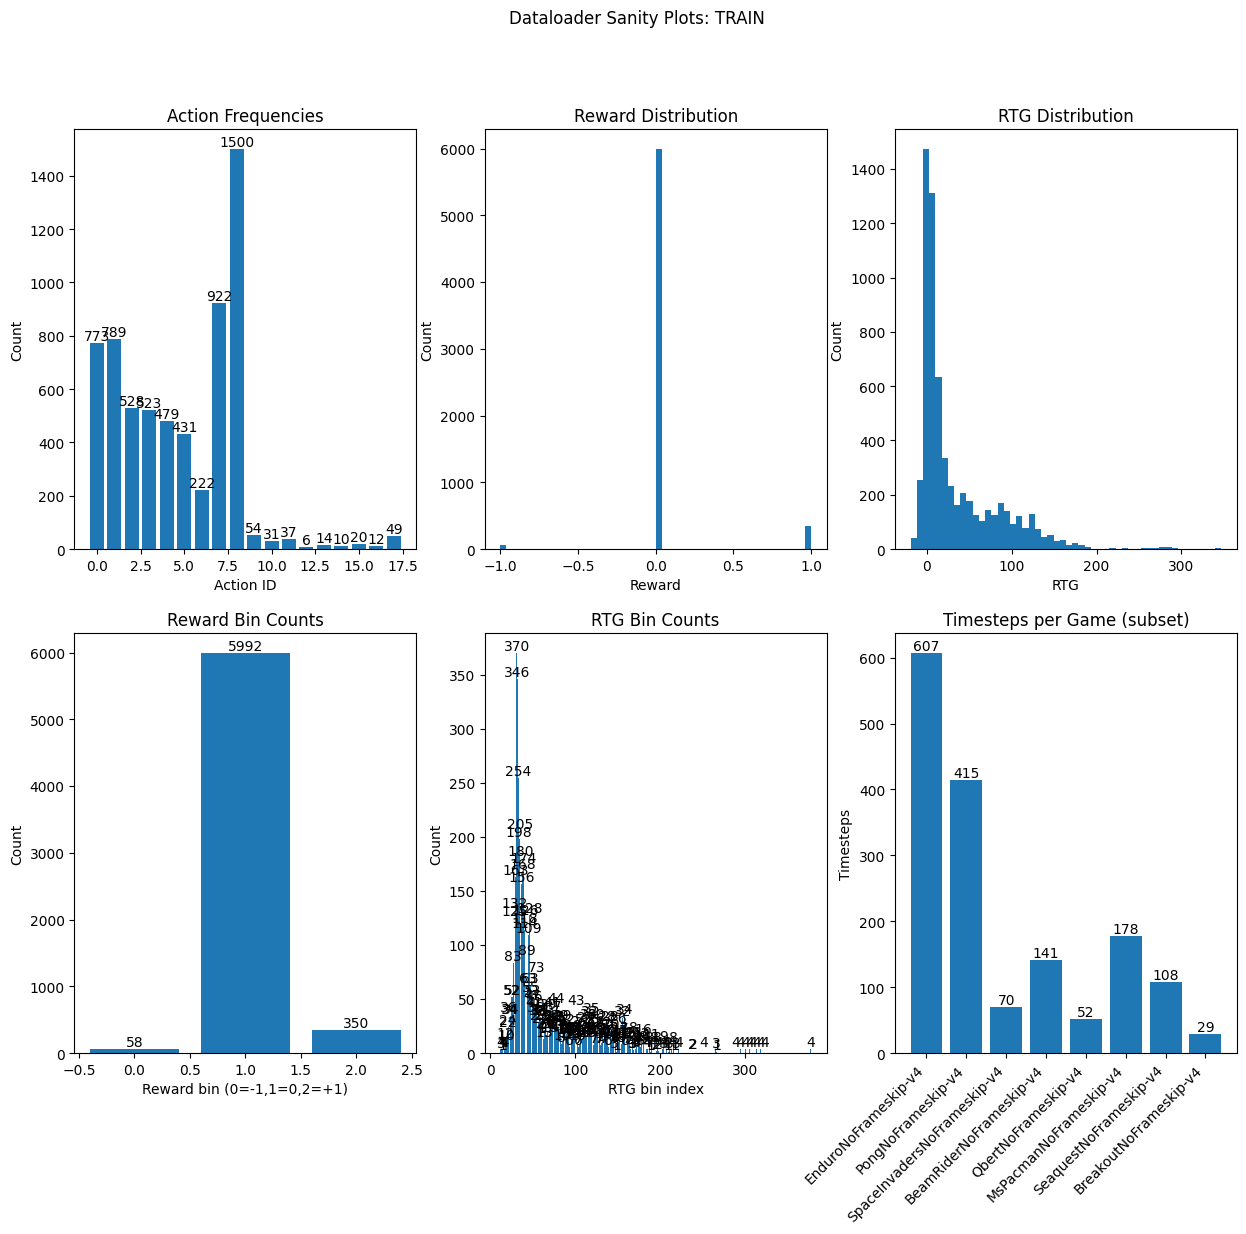

=== Dataloader Sanity Check: VAL ===
Used batches: 50
First batch shapes: {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}
Total samples (timesteps): 6400
Games in subset: 4 -> {'BeamRiderNoFrameskip-v4': 403, 'MsPacmanNoFrameskip-v4': 934, 'BreakoutNoFrameskip-v4': 187, 'SeaquestNoFrameskip-v4': 76}
Actions: min=0, max=17, unique=14
Rewards: min=0.000, max=1.000
RTG: min=0.000, max=124.000
Reward bins: unique=[1 2]
RTG bins: min=31, max=155
NaNs in rewards? False
NaNs in RTG? False
{'first_shapes': {'frames': (32, 4, 3, 84, 84), 'actions': (32, 4), 'rewards': (32, 4), 'rtg': (32, 4)}, 'n_batches_used': 50, 'n_timesteps': 6400, 'game_counts': {'BeamRiderNoFrameskip-v4': 403, 'MsPacmanNoFrameskip-v4': 934, 'BreakoutNoFrameskip-v4': 187, 'SeaquestNoFrameskip-v4': 76}, 'actions_min': 0.0, 'actions_max': 17.0, 'n_unique_actions': 14, 'rewards_min': 0.0, 'rewards_max': 1.0, 'rtg_min': 0.0, 'rtg_max': 124.0, 'reward_bins_unique': array([1, 2]), 'rtg_bins

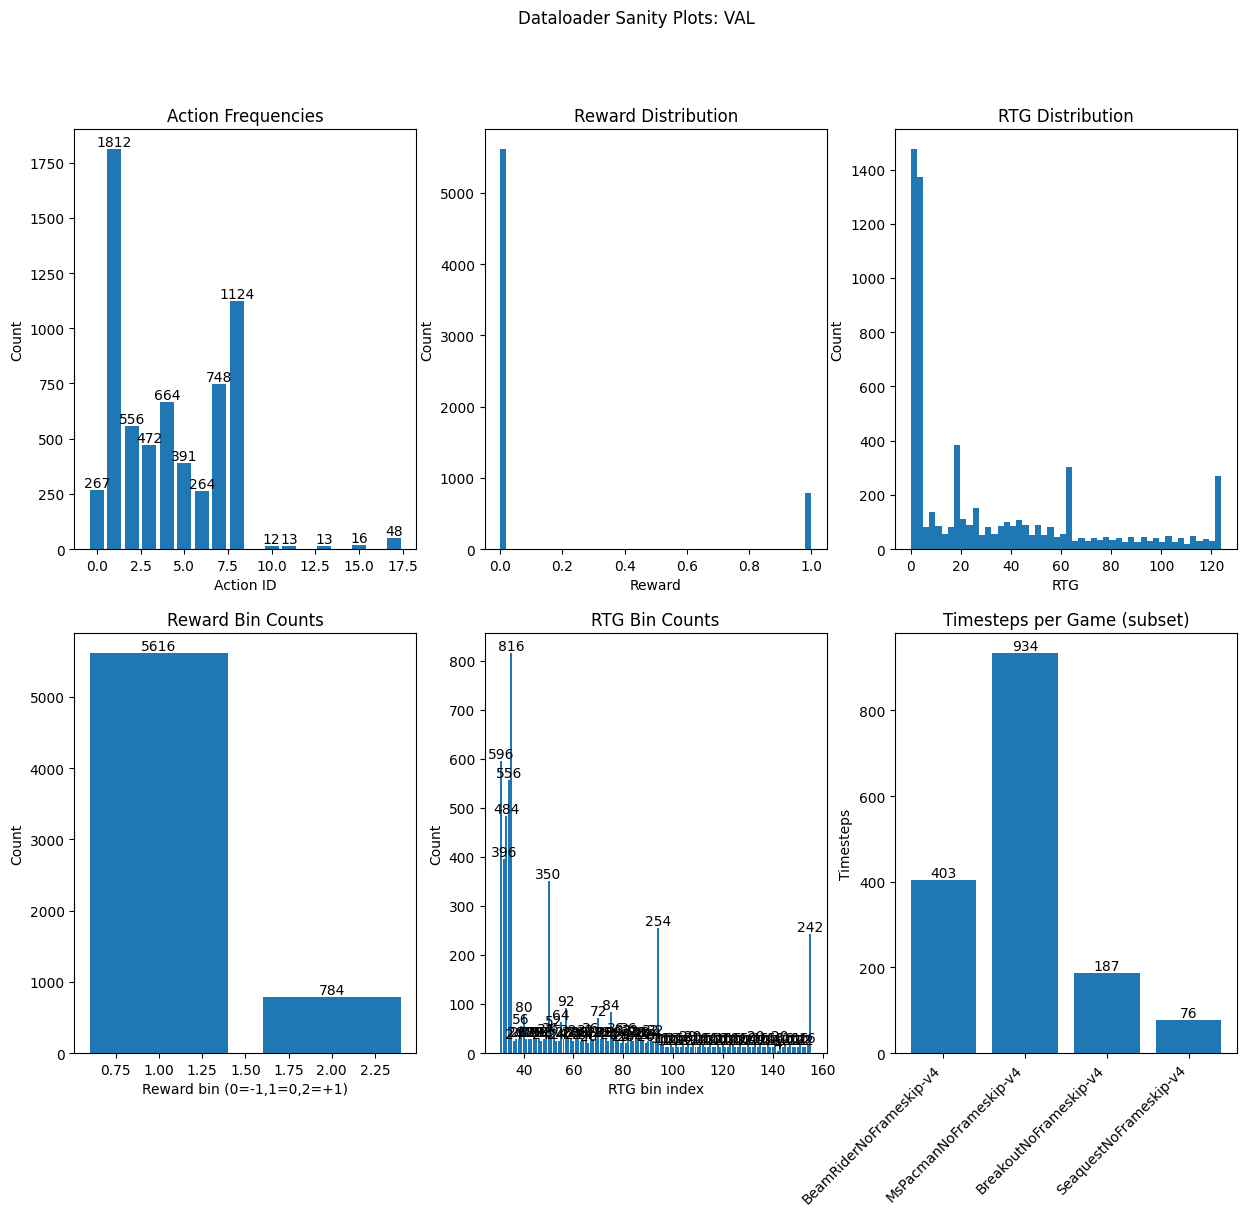

In [6]:
from dataloader_stats import inspect_dataloader

inspect_dataloader(train_loader, "TRAIN")
inspect_dataloader(val_loader, "VAL")

# Train

In [7]:
from mgdt_model_trainer import Encoder, train_mgdt

model, train_stats, val_stats = train_mgdt(
    bins=bins,
    dataloader_train=train_loader,
    dataloader_val=val_loader,
    encoder_type=Encoder.Patch,
)

Validation: 100%|██████████| 6141/6141 [04:46<00:00, 21.42it/s]


# Look at Results

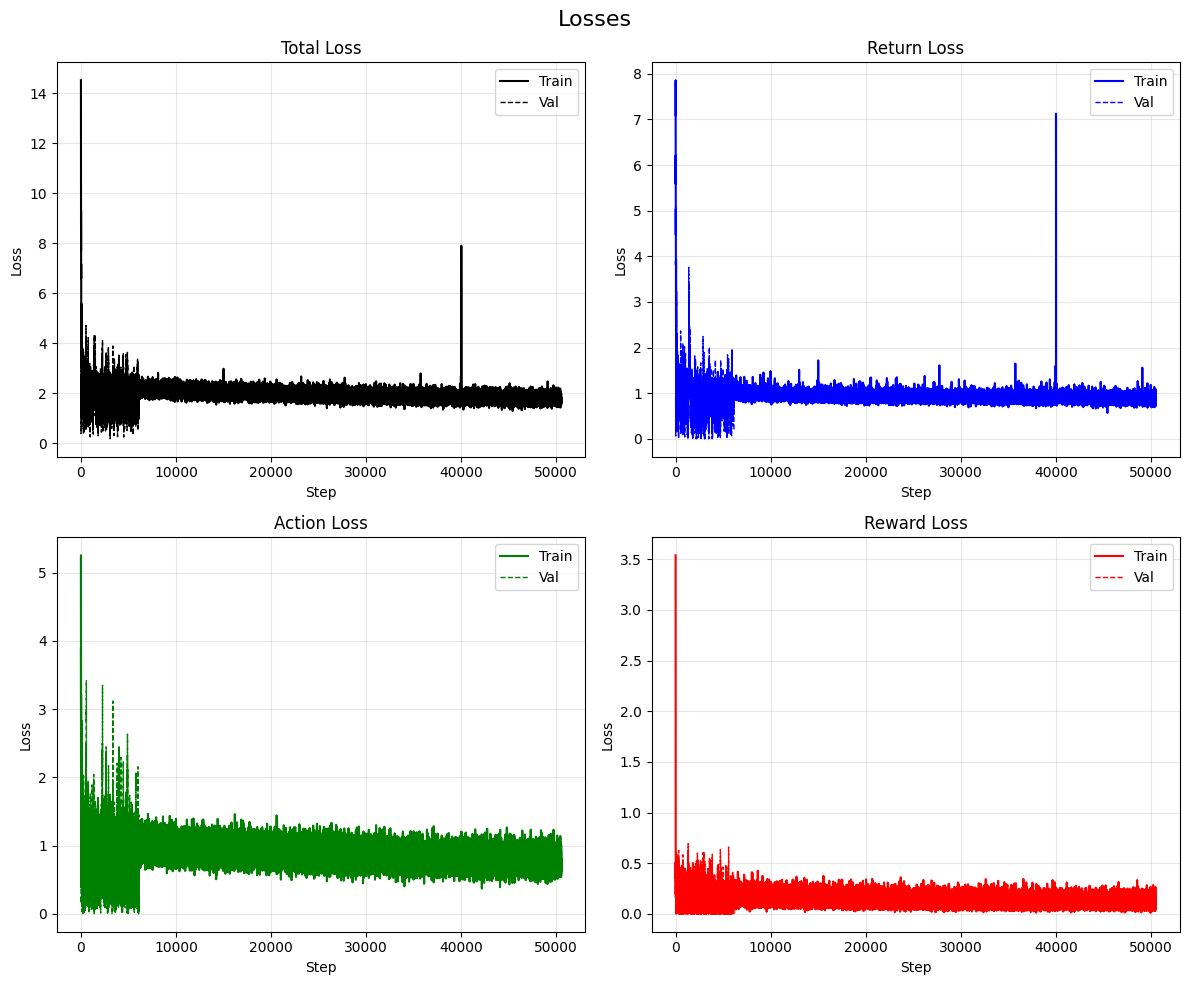

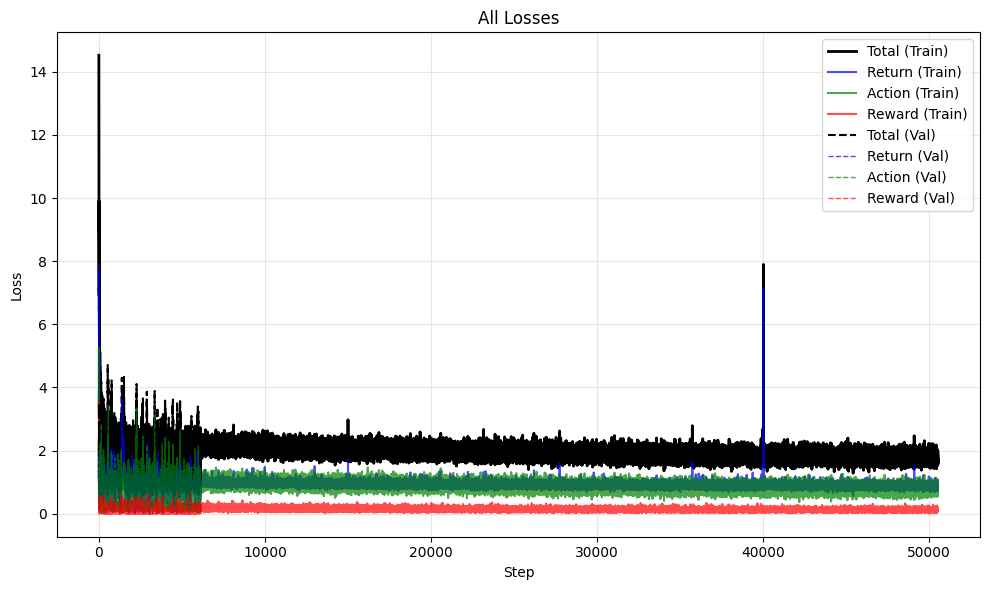

In [8]:
from mgdt_model_stats import plot_losses
plot_losses(train_stats, val_stats)

In [9]:
train_stats[:10]

[{'step': 1,
  'loss': 14.520139694213867,
  'loss_return': 7.091156482696533,
  'loss_action': 3.88942289352417,
  'loss_reward': 3.539560317993164,
  'grad_norm': 0.9999999488736288,
  'return_acc': 0.03125,
  'action_acc': 0.1875,
  'reward_acc': 0.953125},
 {'step': 2,
  'loss': 12.240781784057617,
  'loss_return': 7.857285022735596,
  'loss_action': 3.1368026733398438,
  'loss_reward': 1.2466944456100464,
  'grad_norm': 1.0000000069496897,
  'return_acc': 0.0234375,
  'action_acc': 0.1953125,
  'reward_acc': 0.9453125},
 {'step': 3,
  'loss': 11.60103702545166,
  'loss_return': 6.480953693389893,
  'loss_action': 3.1782329082489014,
  'loss_reward': 1.9418509006500244,
  'grad_norm': 1.0000000221365386,
  'return_acc': 0.0625,
  'action_acc': 0.2421875,
  'reward_acc': 0.9296875},
 {'step': 4,
  'loss': 11.810012817382812,
  'loss_return': 6.4486846923828125,
  'loss_action': 4.60382080078125,
  'loss_reward': 0.7575076818466187,
  'grad_norm': 0.9999999605044144,
  'return_acc': 

In [10]:
val_stats[:10]

[{'step': 1,
  'loss': 1.135017991065979,
  'loss_return': 0.8916621208190918,
  'loss_action': 0.24294237792491913,
  'loss_reward': 0.00041357974987477064,
  'return_acc': 0.75,
  'action_acc': 0.890625,
  'reward_acc': 1.0},
 {'step': 2,
  'loss': 1.530484676361084,
  'loss_return': 0.8902087211608887,
  'loss_action': 0.6400572061538696,
  'loss_reward': 0.00021880283020436764,
  'return_acc': 0.75,
  'action_acc': 0.734375,
  'reward_acc': 1.0},
 {'step': 3,
  'loss': 1.5293687582015991,
  'loss_return': 0.8942047357559204,
  'loss_action': 0.6348550319671631,
  'loss_reward': 0.0003089684760197997,
  'return_acc': 0.75,
  'action_acc': 0.6953125,
  'reward_acc': 1.0},
 {'step': 4,
  'loss': 1.6360993385314941,
  'loss_return': 0.892242968082428,
  'loss_action': 0.7436022162437439,
  'loss_reward': 0.0002542134316172451,
  'return_acc': 0.75,
  'action_acc': 0.5546875,
  'reward_acc': 1.0},
 {'step': 5,
  'loss': 2.3997623920440674,
  'loss_return': 0.87873774766922,
  'loss_acti

In [11]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total parameters: {total_params/1e6:.0f}M")

Total parameters: 20M


In [12]:
import pickle
from pathlib import Path

# Save model to file
model_path = Path("output/model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(model, f)
print(f"Model saved to {model_path}")

Model saved to output\model.pkl
